# Predict Titanic Survival Rates

In [1]:
import featuretools as ft
import featuretools.variable_types as vtypes

import pandas as pd
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

#import sklearn
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import(
    classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
)


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import (
    StandardScaler, LabelBinarizer, Imputer, FunctionTransformer,PolynomialFeatures, OrdinalEncoder
)

from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, SelectPercentile, 
    SelectFromModel, f_regression, RFECV
)

from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.model_selection import GridSearchCV

from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
titanic_df = pd.read_csv('data/train.csv')
test_df= pd.read_csv('data/test.csv')

titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
def make_pair_plot(df_corr):
    # Set the default matplotlib figure size to 7x7:
    fix, ax = plt.subplots(figsize=(5,5))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(df_corr, mask=mask, ax=ax, annot=True, cmap="BrBG")

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

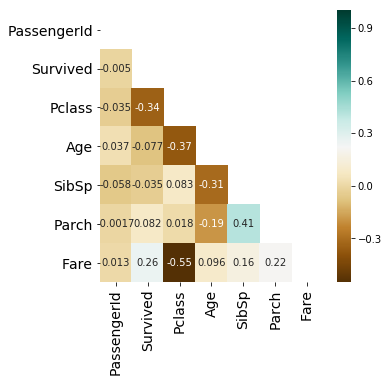

In [6]:
make_pair_plot(titanic_df.corr())

### Train Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(titanic_df.iloc[:,:], titanic_df['Survived'], random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
X_train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
298,299,1,1,"Saalfeld, Mr. Adolphe",male,NaN,0,0,19988,30.5000,C106,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.00,0,0,SOTON/OQ 392076,7.0500,NaN,S
247,248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.00,0,2,250649,14.5000,NaN,S
478,479,0,3,"Karlsson, Mr. Nils August",male,22.00,0,0,350060,7.5208,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S


In [8]:
titanic_df[titanic_df['Survived']==1]['Survived'].sum()/len(titanic_df)

0.3838383838383838

#### Transform DataFrame
* Very Basic DataFrameMapper for now with very simplistic approach to filling in missing values and adapted to work better with FeatureTools
* leave in PassengerId, just encode Pclass and Embarked rather than LabelBInarizing them

In [9]:

mapper = DataFrameMapper([
    
    # PassengerId   --incldude for Feature Tools
    ('PassengerId', None),
     
    #pclass Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
    ('Pclass',[CategoricalImputer(strategy='mode')]),
    ('Name',[CategoricalImputer(strategy='fixed_value',replacement="")]),
    #Sex    male/female
    (['Sex'],  [CategoricalImputer(strategy='mode'), OrdinalEncoder()]),
    (['Age'],[SimpleImputer(strategy='median')]),
    (['SibSp'],[SimpleImputer(strategy='constant', fill_value=0)]),
    (['Parch'],[SimpleImputer(strategy='constant', fill_value=0)]),
    # skipping ticket, fare and cabin for now
    (['Embarked'],[CategoricalImputer(strategy='mode'), OrdinalEncoder()]) 

], df_out=True)


In [10]:
'''
This class performs feature engineering on the retrieved posts.  It is designed to be used in a pipeline
It takes no special input parameters beyond X (the dataframe to be transformed) and returns a modified version of X
with some additional, calculated columns.
Columns Created:

'''
class TitanicTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        X['family_count'] = X['Parch'] + X['SibSp']
        X = X.drop(columns=['Parch','SibSp', 'Name'], axis=1)
    
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [11]:
pipe1a = Pipeline([
    ('map', mapper),
    ('feature_gen', TitanicTransformer())
])

In [12]:
pipe1a = pipe1a.fit(X_train)
X_train = pipe1a.transform(X_train)


In [13]:
# save a copy of this dataframe for later reference
X_train_orig =X_train.copy()
X_train.head()

,PassengerId,Pclass,Sex,Age,Embarked,family_count
298,299,1,1.0,28.00,2.0,0
884,885,3,1.0,25.00,2.0,0
247,248,2,0.0,24.00,2.0,2
478,479,3,1.0,22.00,2.0,0
305,306,1,1.0,0.92,2.0,3


In [14]:
#X_test = mapper.transform(X_test)
X_test =  pipe1a.transform(X_test)
X_test.head()
# save a copy of this dataframe for later reference
X_test_orig = X_test.copy()

### Get Baseline Classification Accuracy Score on this dataframe before we add any new features

#### Start with DecisionTreeClassifier 
* (parameters previously tuned using GridSearchCV on this dataframe)

In [15]:
def run_classification(trainx, testx):
    classifier =DecisionTreeClassifier(criterion='gini',max_depth=2, max_leaf_nodes=20)
    classifier.fit(trainx, y_train)
    Y_pred = classifier.predict(testx)
    print(f"Decision Tree Test score {classifier.score(testx, y_test)}")
    print(f"Decision Tree Confusion Matrix: \n {confusion_matrix(y_test, Y_pred)}")
#     feature_importances = classifier.feature_importances_
#     feature_importances     

    
    lr=LogisticRegression(solver='lbfgs',max_iter=500)
    lr = lr.fit(trainx, y_train)
    print(f"LogisticRegression Test socre {lr.score(testx, y_test)}")
    Y_pred2 = lr.predict(testx)
    print(f"Logistic Regression Confusion Matix:\n {confusion_matrix(y_test, Y_pred2)}")
    
    
    lr_weights = pd.DataFrame({
        'features': testx.columns,
        'importance': lr.coef_[0]
    }) 
    lr_weights.sort_values('importance', ascending=False, inplace=True)
    print(f"LogisticRegression Top Feature Weights\n {lr_weights.head()}")


In [16]:
run_classification(X_train, X_test)

Decision Tree Test score 0.8116591928251121
Decision Tree Confusion Matrix: 
 [[118  16]
 [ 26  63]]
LogisticRegression Test socre 0.8026905829596412
Logistic Regression Confusion Matix:
 [[114  20]
 [ 24  65]]
LogisticRegression Top Feature Weights
        features  importance
0   PassengerId    0.000374
3           Age   -0.032627
5  family_count   -0.176232
4      Embarked   -0.261120
1        Pclass   -1.022389


* we have a baseline accuracy score of .811 with a DecisionTree and .798 with Logistic Regression to beat

### Feature Tools

#### Let's see what Primitives are available out of the box

In [17]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(primitives[primitives['type'] == 'aggregation'].shape[0])

,name,type,description
0,all,aggregation,Test if all values are 'True'.
1,count,aggregation,Counts the number of non null values.
2,num_true,aggregation,Finds the number of 'True' values in a boolean.
3,any,aggregation,Test if any value is 'True'.
4,num_unique,aggregation,Returns the number of unique categorical variables.
5,trend,aggregation,Calculates the slope of the linear trend of variable overtime.
6,std,aggregation,Finds the standard deviation of a numeric feature ignoring null values.
7,n_most_common,aggregation,Finds the N most common elements in a categorical feature.
8,mode,aggregation,Finds the most common element in a categorical feature.
9,avg_time_between,aggregation,Computes the average time between consecutive events.


In [18]:
primitives[primitives['type'] == 'transform'].head(primitives[primitives['type'] == 'transform'].shape[0])

,name,type,description
19,cum_sum,transform,Calculates the sum of previous values of an instance for each value in a time-dependent entity.
20,minutes,transform,Transform a Timedelta feature into the number of minutes.
21,years,transform,Transform a Timedelta feature into the number of years.
22,minute,transform,Transform a Datetime feature into the minute.
23,days_since,transform,"For each value of the base feature, compute the number of days between it"
24,cum_mean,transform,Calculates the mean of previous values of an instance for each value in a time-dependent entity.
25,hours,transform,Transform a Timedelta feature into the number of hours.
26,absolute,transform,Absolute value of base feature.
27,add,transform,Creates a transform feature that adds two features.
28,isin,transform,"For each value of the base feature, checks whether it is in a provided list."


#### Experiment 1 - set up entity and EntitySet
* FeatureTools requires you to set up an overall EntitySet and then add Entities to it. Entities can be thought of as tables in a relational database (i.e. Product, Sales and Customer) or separate dataframes in Python than you are linking together. For the Titanic dataset, I named the EntitySet "Survivors" and added my X_train dataframe as the Passengers entity (using the entity_from_dataframe() function)

In [19]:
# creating and entity set 'es'
es = ft.EntitySet(id = 'Survivors')

# adding a dataframe 
es.entity_from_dataframe(entity_id = 'Passengers', dataframe = X_train, index = 'PassengerId')

Entityset: Survivors
  Entities:
    Passengers [Rows: 668, Columns: 6]
  Relationships:
    No relationships

#### Check the Variables 
* we can check the variables that it has learned and can see that it is treating everything as numeric, when really several of them are categorical.  
* so we will be more explicit when creating our entity

In [20]:
es["Passengers"].variables

[<Variable: PassengerId (dtype = index)>,
 <Variable: Pclass (dtype = numeric)>,
 <Variable: Sex (dtype = numeric)>,
 <Variable: Age (dtype = numeric)>,
 <Variable: Embarked (dtype = numeric)>,
 <Variable: family_count (dtype = numeric)>]

In [21]:

variable_types = { 'PassengerId': vtypes.Categorical,
      'Sex': vtypes.Categorical,
      'Pclass': vtypes.Categorical,
      'Embarked': vtypes.Categorical}

es.entity_from_dataframe(entity_id = 'Passengers', dataframe = X_train, index = 'PassengerId', variable_types=variable_types)

Entityset: Survivors
  Entities:
    Passengers [Rows: 668, Columns: 6]
  Relationships:
    No relationships

In [22]:
es["Passengers"].variables

[<Variable: PassengerId (dtype = index)>,
 <Variable: Age (dtype = numeric)>,
 <Variable: family_count (dtype = numeric)>,
 <Variable: Sex (dtype = categorical)>,
 <Variable: Pclass (dtype = categorical)>,
 <Variable: Embarked (dtype = categorical)>]

#### Now FeatureTools recognizes those columns as being categorical.  Let's try generating some features!
* We call the Deep Feature Synthesis, dfs(), function, telling it what entity to target (Passengers is our only entity in this case) and how deep to go in stacking depth (

In [23]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
    target_entity = 'Passengers', 
    max_depth = 3, 
    verbose = 3, 
    n_jobs = 1)

Built 5 features
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [24]:
feature_matrix.head()

,Age,family_count,Sex,Pclass,Embarked
PassengerId,,,,,
1,22.0,1,1.0,3,2.0
2,38.0,1,0.0,1,0.0
3,26.0,0,0.0,3,2.0
4,35.0,1,0.0,1,2.0
5,35.0,0,1.0,3,2.0


#### Result -- no new columns generated!  
* if we don't have any obvious relationships, we need to create some

In [25]:
es = es.normalize_entity(base_entity_id='Passengers', new_entity_id='Pclass', index='Pclass')

In [26]:
es

Entityset: Survivors
  Entities:
    Passengers [Rows: 668, Columns: 6]
    Pclass [Rows: 3, Columns: 1]
  Relationships:
    Passengers.Pclass -> Pclass.Pclass

In [27]:
es["Pclass"].variables

[<Variable: Pclass (dtype = index)>]

In [28]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
    target_entity = 'Passengers', 
    max_depth = 2, 
    verbose = 3, 
    n_jobs = 1)

Built 22 features
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [29]:
X_train=feature_matrix.copy() # save the generated features back into our X_Train
feature_matrix.head().T

PassengerId,1,2,3,4,5
Age,22.000000,38.000000,26.000000,35.000000,35.000000
family_count,1.000000,1.000000,0.000000,1.000000,0.000000
Sex,1.000000,0.000000,0.000000,0.000000,1.000000
Pclass,3.000000,1.000000,3.000000,1.000000,3.000000
Embarked,2.000000,0.000000,2.000000,2.000000,2.000000
Pclass.SUM(Passengers.Age),9670.920000,5598.920000,9670.920000,5598.920000,9670.920000
Pclass.SUM(Passengers.family_count),386.000000,119.000000,386.000000,119.000000,386.000000
Pclass.STD(Passengers.Age),10.574068,14.234234,10.574068,14.234234,10.574068
Pclass.STD(Passengers.family_count),2.037534,1.091313,2.037534,1.091313,2.037534
Pclass.MAX(Passengers.Age),74.000000,80.000000,74.000000,80.000000,74.000000


#### Great!  Now we have some features.  Let's take a closer look at a few of them

* Pclass.SUM(Passengers.family_count) = for all passengers with PClass=3, sum up the family_count

In [30]:
X_train[X_train['Pclass']==3]['family_count'].sum(), X_train[X_train['Pclass']==1]['family_count'].sum()

(386, 119)

* Pclass.MEAN(Passengers.family_count) = similarly, this is the average family count for all passengers with PClass=3	

In [31]:
X_train[X_train['Pclass']==3]['family_count'].mean(), X_train[X_train['Pclass']==1]['family_count'].mean()

(1.0293333333333334, 0.7828947368421053)

#### Apply to test set
* recommended approach from FeatureLabs on StackOverflow is to encode the features of our training set and then use those saved features to apply to our test set (https://stackoverflow.com/questions/49711987/how-do-i-prevent-data-leakage-with-featuretools)

In [32]:
X_train.shape, X_test.shape

((668, 22), (223, 6))

In [33]:
feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_names, include_unknown=False)

In [34]:
feature_matrix_enc.head()

,Age,family_count,Sex = 1.0,Sex = 0.0,Pclass = 3,Pclass = 1,Pclass = 2,Embarked = 2.0,Embarked = 0.0,Embarked = 1.0,...,Pclass.SKEW(Passengers.family_count),Pclass.MIN(Passengers.Age),Pclass.MIN(Passengers.family_count),Pclass.MEAN(Passengers.Age),Pclass.MEAN(Passengers.family_count),Pclass.COUNT(Passengers),Pclass.NUM_UNIQUE(Passengers.Sex),Pclass.NUM_UNIQUE(Passengers.Embarked),Pclass.MODE(Passengers.Sex) = 1.0,Pclass.MODE(Passengers.Embarked) = 2.0
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,22.0,1,1,0,1,0,0,1,0,0,...,2.564656,0.42,0,25.78912,1.029333,375,2,3,1,1
2,38.0,1,0,1,0,1,0,0,1,0,...,1.960429,0.92,0,36.83500,0.782895,152,2,3,1,1
3,26.0,0,0,1,1,0,0,1,0,0,...,2.564656,0.42,0,25.78912,1.029333,375,2,3,1,1
4,35.0,1,0,1,0,1,0,1,0,0,...,1.960429,0.92,0,36.83500,0.782895,152,2,3,1,1
5,35.0,0,1,0,1,0,0,1,0,0,...,2.564656,0.42,0,25.78912,1.029333,375,2,3,1,1


In [35]:
features_enc

[<Feature: Age>,
 <Feature: family_count>,
 <Feature: Sex = 1.0>,
 <Feature: Sex = 0.0>,
 <Feature: Pclass = 3>,
 <Feature: Pclass = 1>,
 <Feature: Pclass = 2>,
 <Feature: Embarked = 2.0>,
 <Feature: Embarked = 0.0>,
 <Feature: Embarked = 1.0>,
 <Feature: Pclass.SUM(Passengers.Age)>,
 <Feature: Pclass.SUM(Passengers.family_count)>,
 <Feature: Pclass.STD(Passengers.Age)>,
 <Feature: Pclass.STD(Passengers.family_count)>,
 <Feature: Pclass.MAX(Passengers.Age)>,
 <Feature: Pclass.MAX(Passengers.family_count)>,
 <Feature: Pclass.SKEW(Passengers.Age)>,
 <Feature: Pclass.SKEW(Passengers.family_count)>,
 <Feature: Pclass.MIN(Passengers.Age)>,
 <Feature: Pclass.MIN(Passengers.family_count)>,
 <Feature: Pclass.MEAN(Passengers.Age)>,
 <Feature: Pclass.MEAN(Passengers.family_count)>,
 <Feature: Pclass.COUNT(Passengers)>,
 <Feature: Pclass.NUM_UNIQUE(Passengers.Sex)>,
 <Feature: Pclass.NUM_UNIQUE(Passengers.Embarked)>,
 <Feature: Pclass.MODE(Passengers.Sex) = 1.0>,
 <Feature: Pclass.MODE(Passengers

In [36]:
X_train = feature_matrix_enc.copy()
X_train.shape

(668, 27)

#### Now create a new entity set for test and repeat the steps for adding the Passengers and PClass entities

In [37]:
# creating and entity set 'es'
es_tst = ft.EntitySet(id = 'Survivors')
# adding a dataframe 
es_tst.entity_from_dataframe(entity_id = 'Passengers', dataframe = X_test, index = 'PassengerId')
# add PCLass entity
es_tst = es_tst.normalize_entity(base_entity_id='Passengers', new_entity_id='Pclass', index='Pclass')

In [38]:
es_tst

Entityset: Survivors
  Entities:
    Passengers [Rows: 223, Columns: 6]
    Pclass [Rows: 3, Columns: 1]
  Relationships:
    Passengers.Pclass -> Pclass.Pclass

#### Now call calculate_feature_matrix on our test entity set and pass in the list of saved features from training

In [39]:
feature_matrix_tst = ft.calculate_feature_matrix(features=features_enc, entityset=es_tst)

In [40]:
X_test = feature_matrix_tst.copy()
X_test.head()

,Age,family_count,Sex = 1.0,Sex = 0.0,Pclass = 3,Pclass = 1,Pclass = 2,Embarked = 2.0,Embarked = 0.0,Embarked = 1.0,...,Pclass.SKEW(Passengers.family_count),Pclass.MIN(Passengers.Age),Pclass.MIN(Passengers.family_count),Pclass.MEAN(Passengers.Age),Pclass.MEAN(Passengers.family_count),Pclass.COUNT(Passengers),Pclass.NUM_UNIQUE(Passengers.Sex),Pclass.NUM_UNIQUE(Passengers.Embarked),Pclass.MODE(Passengers.Sex) = 1.0,Pclass.MODE(Passengers.Embarked) = 2.0
PassengerId,,,,,,,,,,,,,,,,,,,,,
6,28.0,0,True,False,True,False,False,False,False,True,...,1.852647,2.0,0,26.396552,0.939655,116,2,3,True,True
8,2.0,4,True,False,True,False,False,True,False,False,...,1.852647,2.0,0,26.396552,0.939655,116,2,3,True,True
11,4.0,2,False,True,True,False,False,True,False,False,...,1.852647,2.0,0,26.396552,0.939655,116,2,3,True,True
24,28.0,0,True,False,False,True,False,True,False,False,...,1.311006,11.0,0,36.757812,0.750000,64,2,3,True,False
26,38.0,6,False,True,True,False,False,True,False,False,...,1.852647,2.0,0,26.396552,0.939655,116,2,3,True,True


In [41]:
X_train.shape, X_test.shape

((668, 27), (223, 27))

### Lesson -- output can contain nulls, so need to trim

In [42]:
# double check for nulls
for col in X_train.columns:
    if X_train[col].isnull().sum() >0:
        print(col)
        X_train.drop(col, axis=1, inplace=True)

### Try Classification model

In [43]:
run_classification(X_train, X_test)

Decision Tree Test score 0.600896860986547
Decision Tree Confusion Matrix: 
 [[134   0]
 [ 89   0]]
LogisticRegression Test socre 0.600896860986547
Logistic Regression Confusion Matix:
 [[134   0]
 [ 89   0]]
LogisticRegression Top Feature Weights
                                features  importance
1                          family_count    0.111879
7                        Embarked = 2.0    0.019096
3                             Sex = 0.0    0.010207
0                                   Age    0.009987
11  Pclass.SUM(Passengers.family_count)    0.001938


### Result = Bad!
* not only is the accuracy score worse than before we added any new Features, but the Confusion Matrix shows that that the model is now just predicting that everyone dies
* clearly something is going wrong...

### Try Removing highly correlated features?
* maybe we have too many correlated features?  Let's try stripping some out (thanks to https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/)

In [44]:
# Threshold for removing correlated variables
threshold = 0.7

# Absolute value correlation matrix
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head(50)

,Age,family_count,Sex = 1.0,Sex = 0.0,Pclass = 3,Pclass = 1,Pclass = 2,Embarked = 2.0,Embarked = 0.0,Embarked = 1.0,...,Pclass.SKEW(Passengers.family_count),Pclass.MIN(Passengers.Age),Pclass.MIN(Passengers.family_count),Pclass.MEAN(Passengers.Age),Pclass.MEAN(Passengers.family_count),Pclass.COUNT(Passengers),Pclass.NUM_UNIQUE(Passengers.Sex),Pclass.NUM_UNIQUE(Passengers.Embarked),Pclass.MODE(Passengers.Sex) = 1.0,Pclass.MODE(Passengers.Embarked) = 2.0
Age,NaN,0.240647,0.079907,0.079907,0.291378,0.320946,0.024582,0.028562,0.002124,0.041735,...,0.178306,0.339140,NaN,0.342468,0.303701,0.285448,NaN,NaN,NaN,NaN
family_count,NaN,NaN,0.182344,0.182344,0.068676,0.046124,0.036124,0.088885,0.063837,0.052630,...,0.058963,0.064896,NaN,0.061064,0.068859,0.068480,NaN,NaN,NaN,NaN
Sex = 1.0,NaN,NaN,NaN,1.000000,0.124292,0.104508,0.043769,0.100472,0.082070,0.046111,...,0.094646,0.128164,NaN,0.124518,0.126562,0.123081,NaN,NaN,NaN,NaN
Sex = 0.0,NaN,NaN,NaN,NaN,0.124292,0.104508,0.043769,0.100472,0.082070,0.046111,...,0.094646,0.128164,NaN,0.124518,0.126562,0.123081,NaN,NaN,NaN,NaN
Pclass = 3,NaN,NaN,NaN,NaN,NaN,0.614015,0.585175,0.032651,0.132399,0.229708,...,0.891601,0.915625,NaN,0.850818,0.997349,0.999484,NaN,NaN,NaN,NaN
Pclass = 1,NaN,NaN,NaN,NaN,NaN,NaN,0.280738,0.115147,0.247794,0.154677,...,0.190047,0.879530,NaN,0.937158,0.669826,0.588350,NaN,NaN,NaN,NaN
Pclass = 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.158004,0.093582,0.120413,...,0.888939,0.209790,NaN,0.071779,0.524612,0.610916,NaN,NaN,NaN,NaN
Embarked = 2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.773431,0.517551,...,0.106674,0.038966,NaN,0.062224,0.020100,0.038135,NaN,NaN,NaN,NaN
Embarked = 0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142091,...,0.022526,0.206035,NaN,0.223491,0.147399,0.125556,NaN,NaN,NaN,NaN
Embarked = 1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.196986,0.217270,NaN,0.204515,0.230355,0.229034,NaN,NaN,NaN,NaN


In [45]:
# Select columns with correlations above threshold
collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d features to remove.' % (len(collinear_features)))

There are 14 features to remove.


In [46]:
X_train_flt = X_train.drop(columns = collinear_features)
X_test_flt = X_test.drop(columns = collinear_features)
X_train_flt.shape, X_test_flt.shape


((668, 13), (223, 13))

In [47]:
X_train_flt.head().T

PassengerId,1,2,3,4,5
Age,22.0,38.0,26.0,35.0,35.0
family_count,1.0,1.0,0.0,1.0,0.0
Sex = 1.0,1.0,0.0,0.0,0.0,1.0
Pclass = 3,1.0,0.0,1.0,0.0,1.0
Pclass = 1,0.0,1.0,0.0,1.0,0.0
Pclass = 2,0.0,0.0,0.0,0.0,0.0
Embarked = 2.0,1.0,0.0,1.0,1.0,1.0
Embarked = 1.0,0.0,0.0,0.0,0.0,0.0
Pclass.MIN(Passengers.family_count),0.0,0.0,0.0,0.0,0.0
Pclass.NUM_UNIQUE(Passengers.Sex),2.0,2.0,2.0,2.0,2.0


#### Retest Decision Tree

In [48]:
run_classification(X_train_flt, X_test_flt)

Decision Tree Test score 0.5874439461883408
Decision Tree Confusion Matrix: 
 [[122  12]
 [ 80   9]]
LogisticRegression Test socre 0.5964125560538116
Logistic Regression Confusion Matix:
 [[130   4]
 [ 86   3]]
LogisticRegression Top Feature Weights
                               features  importance
6                       Embarked = 2.0    0.127458
3                           Pclass = 3    0.120903
1                         family_count    0.097890
0                                  Age    0.009780
8  Pclass.MIN(Passengers.family_count)    0.000000


#### Result: Accuracy score is still poor and our confusion matrix is still tending to predict that everyone dies
#### What's going on here??

## Wait, is our dataframe still in the same order as our y dataframe?
* it doesn't make sense that adding some additional features would completely destroy the predictive power of our model
* could it be that our X_Train/X_test dataframes were reordered during the feature generation process?

In [49]:
X_train.head()

,Age,family_count,Sex = 1.0,Sex = 0.0,Pclass = 3,Pclass = 1,Pclass = 2,Embarked = 2.0,Embarked = 0.0,Embarked = 1.0,...,Pclass.SKEW(Passengers.family_count),Pclass.MIN(Passengers.Age),Pclass.MIN(Passengers.family_count),Pclass.MEAN(Passengers.Age),Pclass.MEAN(Passengers.family_count),Pclass.COUNT(Passengers),Pclass.NUM_UNIQUE(Passengers.Sex),Pclass.NUM_UNIQUE(Passengers.Embarked),Pclass.MODE(Passengers.Sex) = 1.0,Pclass.MODE(Passengers.Embarked) = 2.0
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,22.0,1,1,0,1,0,0,1,0,0,...,2.564656,0.42,0,25.78912,1.029333,375,2,3,1,1
2,38.0,1,0,1,0,1,0,0,1,0,...,1.960429,0.92,0,36.83500,0.782895,152,2,3,1,1
3,26.0,0,0,1,1,0,0,1,0,0,...,2.564656,0.42,0,25.78912,1.029333,375,2,3,1,1
4,35.0,1,0,1,0,1,0,1,0,0,...,1.960429,0.92,0,36.83500,0.782895,152,2,3,1,1
5,35.0,0,1,0,1,0,0,1,0,0,...,2.564656,0.42,0,25.78912,1.029333,375,2,3,1,1


In [50]:
X_train_orig.head()

,PassengerId,Pclass,Sex,Age,Embarked,family_count
298,299,1,1.0,28.00,2.0,0
884,885,3,1.0,25.00,2.0,0
247,248,2,0.0,24.00,2.0,2
478,479,3,1.0,22.00,2.0,0
305,306,1,1.0,0.92,2.0,3


* yes, we can see from the age column that our dataframe has been reordered!

## Lesson -- the order of our data frame was not preserved! If you do a train/test split before calling FeatureTools, you need to take extra steps to preserve it

* our original X_train and X_test dataframes are shuffled, so let's reset the index to an ascending sequence

In [51]:
X_train_orig.reset_index(drop=True, inplace=True)
X_test_orig.reset_index(drop=True, inplace=True)
X_train_orig.head()

,PassengerId,Pclass,Sex,Age,Embarked,family_count
0,299,1,1.0,28.00,2.0,0
1,885,3,1.0,25.00,2.0,0
2,248,2,0.0,24.00,2.0,2
3,479,3,1.0,22.00,2.0,0
4,306,1,1.0,0.92,2.0,3


* let's preserve the PassengerID column rather than using it as our index 

In [52]:
# creating and entity set 'es'
es = ft.EntitySet(id = 'Survivors')
variable_types = { 
      'Sex': vtypes.Categorical,
      'Pclass': vtypes.Categorical,
      'Embarked': vtypes.Categorical}

es.entity_from_dataframe(entity_id = 'Passengers', dataframe = X_train_orig, index = 'Id', variable_types=variable_types)

2018-11-09 14:01:49,122 featuretools.entityset - WARNING    index Id not found in dataframe, creating new integer column


Entityset: Survivors
  Entities:
    Passengers [Rows: 668, Columns: 7]
  Relationships:
    No relationships

In [53]:
es["Passengers"].variables

[<Variable: Id (dtype = index)>,
 <Variable: PassengerId (dtype = numeric)>,
 <Variable: Age (dtype = numeric)>,
 <Variable: family_count (dtype = numeric)>,
 <Variable: Sex (dtype = categorical)>,
 <Variable: Pclass (dtype = categorical)>,
 <Variable: Embarked (dtype = categorical)>]

In [54]:
es = es.normalize_entity(base_entity_id='Passengers', new_entity_id='Pclass', index='Pclass')

In [55]:
es

Entityset: Survivors
  Entities:
    Passengers [Rows: 668, Columns: 7]
    Pclass [Rows: 3, Columns: 1]
  Relationships:
    Passengers.Pclass -> Pclass.Pclass

*  tell DFS to ignore the PassengerId column( we don't want to generate any features for it) using the command ignore_variables={'Passengers':['PassengerId']}),

In [56]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
    target_entity = 'Passengers', 
    max_depth = 2, 
    verbose = 3, 
    n_jobs = 1,
    ignore_variables={'Passengers':['PassengerId']})

Built 22 features
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [57]:
X_train=feature_matrix.copy() # save the generated features back into our X_Train
feature_matrix.head().T

Id,0,1,2,3,4
Age,28.000000,25.000000,24.000000,22.000000,0.920000
family_count,0.000000,0.000000,2.000000,0.000000,3.000000
Sex,1.000000,1.000000,0.000000,1.000000,1.000000
Pclass,1.000000,3.000000,2.000000,3.000000,1.000000
Embarked,2.000000,2.000000,2.000000,2.000000,2.000000
Pclass.SUM(Passengers.Age),5598.920000,9670.920000,4196.000000,9670.920000,5598.920000
Pclass.SUM(Passengers.family_count),119.000000,386.000000,114.000000,386.000000,119.000000
Pclass.STD(Passengers.Age),14.234234,10.574068,13.996094,10.574068,14.234234
Pclass.STD(Passengers.family_count),1.091313,2.037534,1.101395,2.037534,1.091313
Pclass.MAX(Passengers.Age),80.000000,74.000000,70.000000,74.000000,80.000000


In [58]:
X_train.head()

,Age,family_count,Sex,Pclass,Embarked,Pclass.SUM(Passengers.Age),Pclass.SUM(Passengers.family_count),Pclass.STD(Passengers.Age),Pclass.STD(Passengers.family_count),Pclass.MAX(Passengers.Age),...,Pclass.SKEW(Passengers.family_count),Pclass.MIN(Passengers.Age),Pclass.MIN(Passengers.family_count),Pclass.MEAN(Passengers.Age),Pclass.MEAN(Passengers.family_count),Pclass.COUNT(Passengers),Pclass.NUM_UNIQUE(Passengers.Sex),Pclass.NUM_UNIQUE(Passengers.Embarked),Pclass.MODE(Passengers.Sex),Pclass.MODE(Passengers.Embarked)
Id,,,,,,,,,,,,,,,,,,,,,
0,28.00,0,1.0,1,2.0,5598.92,119,14.234234,1.091313,80.0,...,1.960429,0.92,0,36.835000,0.782895,152,2,3,1.0,2.0
1,25.00,0,1.0,3,2.0,9670.92,386,10.574068,2.037534,74.0,...,2.564656,0.42,0,25.789120,1.029333,375,2,3,1.0,2.0
2,24.00,2,0.0,2,2.0,4196.00,114,13.996094,1.101395,70.0,...,1.234036,0.67,0,29.758865,0.808511,141,2,3,1.0,2.0
3,22.00,0,1.0,3,2.0,9670.92,386,10.574068,2.037534,74.0,...,2.564656,0.42,0,25.789120,1.029333,375,2,3,1.0,2.0
4,0.92,3,1.0,1,2.0,5598.92,119,14.234234,1.091313,80.0,...,1.960429,0.92,0,36.835000,0.782895,152,2,3,1.0,2.0


* Repeat the steps for Encoding our training set

In [59]:
feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_names, include_unknown=False)

In [60]:
feature_matrix_enc.head()

,Age,family_count,Sex = 1.0,Sex = 0.0,Pclass = 3,Pclass = 1,Pclass = 2,Embarked = 2.0,Embarked = 0.0,Embarked = 1.0,...,Pclass.SKEW(Passengers.family_count),Pclass.MIN(Passengers.Age),Pclass.MIN(Passengers.family_count),Pclass.MEAN(Passengers.Age),Pclass.MEAN(Passengers.family_count),Pclass.COUNT(Passengers),Pclass.NUM_UNIQUE(Passengers.Sex),Pclass.NUM_UNIQUE(Passengers.Embarked),Pclass.MODE(Passengers.Sex) = 1.0,Pclass.MODE(Passengers.Embarked) = 2.0
Id,,,,,,,,,,,,,,,,,,,,,
0,28.00,0,1,0,0,1,0,1,0,0,...,1.960429,0.92,0,36.835000,0.782895,152,2,3,1,1
1,25.00,0,1,0,1,0,0,1,0,0,...,2.564656,0.42,0,25.789120,1.029333,375,2,3,1,1
2,24.00,2,0,1,0,0,1,1,0,0,...,1.234036,0.67,0,29.758865,0.808511,141,2,3,1,1
3,22.00,0,1,0,1,0,0,1,0,0,...,2.564656,0.42,0,25.789120,1.029333,375,2,3,1,1
4,0.92,3,1,0,0,1,0,1,0,0,...,1.960429,0.92,0,36.835000,0.782895,152,2,3,1,1


In [61]:
X_train = feature_matrix_enc.copy()
X_train.head()

,Age,family_count,Sex = 1.0,Sex = 0.0,Pclass = 3,Pclass = 1,Pclass = 2,Embarked = 2.0,Embarked = 0.0,Embarked = 1.0,...,Pclass.SKEW(Passengers.family_count),Pclass.MIN(Passengers.Age),Pclass.MIN(Passengers.family_count),Pclass.MEAN(Passengers.Age),Pclass.MEAN(Passengers.family_count),Pclass.COUNT(Passengers),Pclass.NUM_UNIQUE(Passengers.Sex),Pclass.NUM_UNIQUE(Passengers.Embarked),Pclass.MODE(Passengers.Sex) = 1.0,Pclass.MODE(Passengers.Embarked) = 2.0
Id,,,,,,,,,,,,,,,,,,,,,
0,28.00,0,1,0,0,1,0,1,0,0,...,1.960429,0.92,0,36.835000,0.782895,152,2,3,1,1
1,25.00,0,1,0,1,0,0,1,0,0,...,2.564656,0.42,0,25.789120,1.029333,375,2,3,1,1
2,24.00,2,0,1,0,0,1,1,0,0,...,1.234036,0.67,0,29.758865,0.808511,141,2,3,1,1
3,22.00,0,1,0,1,0,0,1,0,0,...,2.564656,0.42,0,25.789120,1.029333,375,2,3,1,1
4,0.92,3,1,0,0,1,0,1,0,0,...,1.960429,0.92,0,36.835000,0.782895,152,2,3,1,1


In [62]:
X_train_orig.head()

,PassengerId,Pclass,Sex,Age,Embarked,family_count
0,299,1,1.0,28.00,2.0,0
1,885,3,1.0,25.00,2.0,0
2,248,2,0.0,24.00,2.0,2
3,479,3,1.0,22.00,2.0,0
4,306,1,1.0,0.92,2.0,3


#### Now create a new entity set for test and repeat the steps for adding the Passengers and PClass entities

In [63]:
# creating and entity set 'es'
es_tst = ft.EntitySet(id = 'Survivors')
# adding a dataframe 
es_tst.entity_from_dataframe(entity_id = 'Passengers', dataframe = X_test_orig, index = 'Id')
# add PCLass entity
es_tst = es_tst.normalize_entity(base_entity_id='Passengers', new_entity_id='Pclass', index='Pclass')

2018-11-09 14:01:50,783 featuretools.entityset - WARNING    index Id not found in dataframe, creating new integer column


In [64]:
es_tst

Entityset: Survivors
  Entities:
    Passengers [Rows: 223, Columns: 7]
    Pclass [Rows: 3, Columns: 1]
  Relationships:
    Passengers.Pclass -> Pclass.Pclass

#### Now call calculate_feature_matrix on our test entity set and pass in the list of saved features from training

In [65]:
feature_matrix_tst = ft.calculate_feature_matrix(features=features_enc, entityset=es_tst)

In [66]:
X_test = feature_matrix_tst.copy()
X_test.head()

,Age,family_count,Sex = 1.0,Sex = 0.0,Pclass = 3,Pclass = 1,Pclass = 2,Embarked = 2.0,Embarked = 0.0,Embarked = 1.0,...,Pclass.SKEW(Passengers.family_count),Pclass.MIN(Passengers.Age),Pclass.MIN(Passengers.family_count),Pclass.MEAN(Passengers.Age),Pclass.MEAN(Passengers.family_count),Pclass.COUNT(Passengers),Pclass.NUM_UNIQUE(Passengers.Sex),Pclass.NUM_UNIQUE(Passengers.Embarked),Pclass.MODE(Passengers.Sex) = 1.0,Pclass.MODE(Passengers.Embarked) = 2.0
Id,,,,,,,,,,,,,,,,,,,,,
0,28.0,2,True,False,True,False,False,False,True,False,...,1.852647,2.00,0,26.396552,0.939655,116,2,3,True,True
1,31.0,0,True,False,False,False,True,True,False,False,...,0.864271,0.83,0,29.786744,0.697674,43,2,2,False,True
2,20.0,0,True,False,True,False,False,True,False,False,...,1.852647,2.00,0,26.396552,0.939655,116,2,3,True,True
3,6.0,1,False,True,False,False,True,True,False,False,...,0.864271,0.83,0,29.786744,0.697674,43,2,2,False,True
4,14.0,1,False,True,True,False,False,False,True,False,...,1.852647,2.00,0,26.396552,0.939655,116,2,3,True,True


In [67]:
X_train.shape, X_test.shape

((668, 27), (223, 27))

In [68]:
X_test_orig.head()

,PassengerId,Pclass,Sex,Age,Embarked,family_count
0,710,3,1.0,28.0,0.0,2
1,440,2,1.0,31.0,2.0,0
2,841,3,1.0,20.0,2.0,0
3,721,2,0.0,6.0,2.0,1
4,40,3,0.0,14.0,0.0,1


### Remove any null values

In [69]:
# double check for nulls
for col in X_train.columns:
    if X_train[col].isnull().sum() >0:
        print(col)
        X_train.drop(col, axis=1, inplace=True)

### Try Classification model

In [70]:
run_classification(X_train, X_test)

Decision Tree Test score 0.7847533632286996
Decision Tree Confusion Matrix: 
 [[111  23]
 [ 25  64]]
LogisticRegression Test socre 0.7847533632286996
Logistic Regression Confusion Matix:
 [[113  21]
 [ 27  62]]
LogisticRegression Top Feature Weights
                        features  importance
3                     Sex = 0.0    1.323965
8                Embarked = 0.0    0.211810
9                Embarked = 1.0    0.110081
14   Pclass.MAX(Passengers.Age)    0.017116
20  Pclass.MEAN(Passengers.Age)    0.007582


#### Now remove any highly correlated features

In [71]:
# Threshold for removing correlated variables
threshold = 0.7

# Absolute value correlation matrix
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [72]:
# Select columns with correlations above threshold
collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d features to remove.' % (len(collinear_features)))

There are 14 features to remove.


In [73]:
X_train_flt = X_train.drop(columns = collinear_features)
X_test_flt = X_test.drop(columns = collinear_features)
X_train_flt.shape, X_test_flt.shape


((668, 13), (223, 13))

In [74]:
X_train_flt.head().T

Id,0,1,2,3,4
Age,28.0,25.0,24.0,22.0,0.92
family_count,0.0,0.0,2.0,0.0,3.00
Sex = 1.0,1.0,1.0,0.0,1.0,1.00
Pclass = 3,0.0,1.0,0.0,1.0,0.00
Pclass = 1,1.0,0.0,0.0,0.0,1.00
Pclass = 2,0.0,0.0,1.0,0.0,0.00
Embarked = 2.0,1.0,1.0,1.0,1.0,1.00
Embarked = 1.0,0.0,0.0,0.0,0.0,0.00
Pclass.MIN(Passengers.family_count),0.0,0.0,0.0,0.0,0.00
Pclass.NUM_UNIQUE(Passengers.Sex),2.0,2.0,2.0,2.0,2.00


* Retest

In [75]:
run_classification(X_train_flt, X_test_flt)

Decision Tree Test score 0.8116591928251121
Decision Tree Confusion Matrix: 
 [[118  16]
 [ 26  63]]
LogisticRegression Test socre 0.8026905829596412
Logistic Regression Confusion Matix:
 [[115  19]
 [ 25  64]]
LogisticRegression Top Feature Weights
                                   features  importance
4                               Pclass = 1    0.878679
5                               Pclass = 2    0.213271
8      Pclass.MIN(Passengers.family_count)    0.000000
11       Pclass.MODE(Passengers.Sex) = 1.0   -0.000517
12  Pclass.MODE(Passengers.Embarked) = 2.0   -0.000517


### Let's visualize what the DecisionTree has learned

In [76]:
classifier =DecisionTreeClassifier(criterion='gini',max_depth=2, max_leaf_nodes=20)
classifier.fit(X_train_flt, y_train)
#Y_pred = classifier.predict(testx)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [77]:
feature_importances = classifier.feature_importances_
pd.DataFrame({
    'features': X_train_flt.columns,
    'importance': feature_importances
})    


,features,importance
0,Age,0.086707
1,family_count,0.092078
2,Sex = 1.0,0.612034
3,Pclass = 3,0.168510
4,Pclass = 1,0.040671
5,Pclass = 2,0.000000
6,Embarked = 2.0,0.000000
7,Embarked = 1.0,0.000000
8,Pclass.MIN(Passengers.family_count),0.000000
9,Pclass.NUM_UNIQUE(Passengers.Sex),0.000000


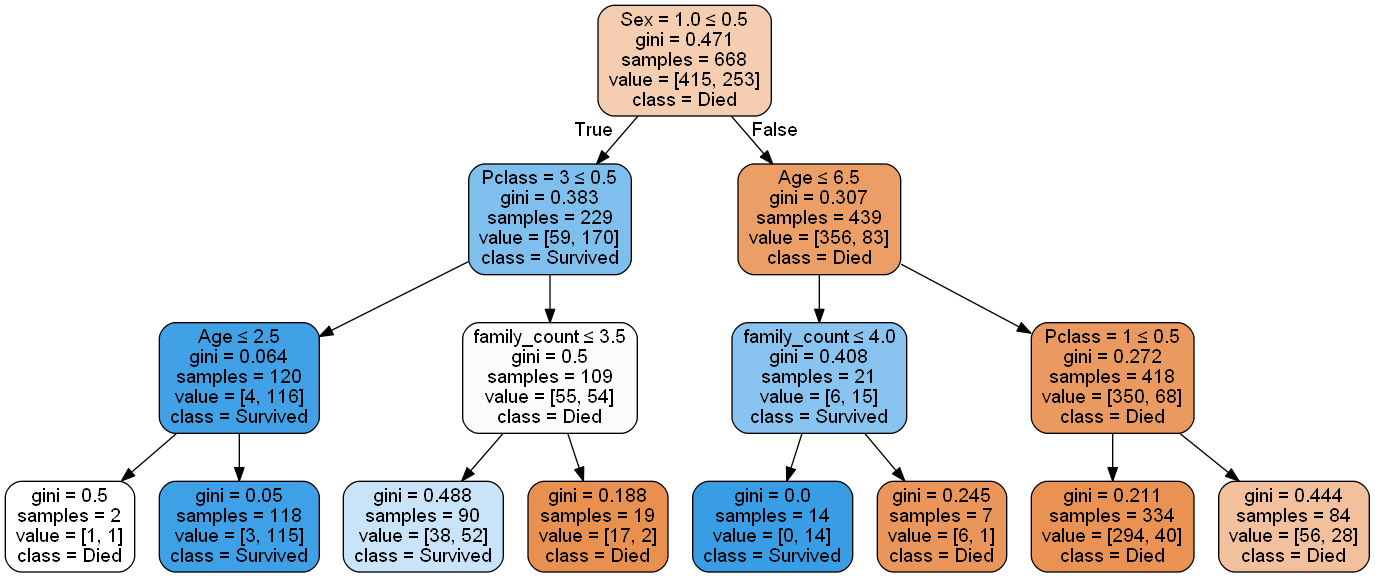

In [78]:
# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()  

export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                 feature_names=X_train_flt.columns,
        class_names=["Died", "Survived"])  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  